<a href="https://colab.research.google.com/github/peeyushsinghal/EVA8/blob/main/S4-Assignment-Solution/EVA8_S4_Experiment5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Objective / Target of Experiment 5
**Objective / Target**
* Increase accuracy
* Find other ways, may be transformation to prop up the accuarcy, trying transformation 

**Results**

* Parameters: 9,990
* Best Train Accuracy: 99.03 %
* Best Test Accuracy: 99.33%

**Analysis**

* Not hitting the accuracy mark
* Overfitting (train - test accuracy) < 0 is largely containted, model underfits (Target not achieved)
* LR has played its role to move up the accuracy
* Number of params < 10K

**Next Steps**

* Find other ways, may be transformation to prop up the accuarcy


# Importing Libraries

In [1]:
import torch
from torchvision import datasets,transforms
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt # for visualizing images
import random # for random image index
import torch.nn as nn # for network
import torch.nn.functional as F # for forward method
import torch.optim as optim # for optimizer
!pip install torchsummary
from torchsummary import summary # for model summary and params
from tqdm import tqdm # for beautiful model training updates

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Seed and Cuda

In [2]:
# check for cuda
cuda = torch.cuda.is_available()
print (f' Cuda Status : {cuda}')

# setting seed
SEED = 42 # arbit seed, why 42 - because in hitch hikers guide to galaxy it is answer to everything
# torch.cuda.seed(SEED) 
torch.cuda.manual_seed_all(SEED) if cuda else torch.manual_seed(SEED)

 Cuda Status : True


# Data Transformations

In [3]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                       transforms.ToTensor(), # converts to tesnor
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),# converts to tesnor
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train / Test Split

In [4]:
train = datasets.MNIST('./data', # directory where data needs to be stored
                       train=True, # get the training portion of the dataset
                       download=True, # downloads
                       transform=train_transforms)
test = datasets.MNIST('./data', 
                      train=False, 
                      download=True, 
                      transform=test_transforms)

## Data Loader

In [5]:
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory = True) if cuda else dict(shuffle=True, batch_size=64)

train_loader = torch.utils.data.DataLoader(
    dataset=train,# train dataset
    **dataloader_args # the dataloader arguments change dependent on cuda is available or not
    )

test_loader = torch.utils.data.DataLoader(
    dataset = test,# test dataset 
    **dataloader_args # the dataloader arguments change dependent on cuda is available or not
)

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


## Checking Dataloader

torch.Size([128, 1, 28, 28])
torch.Size([128])


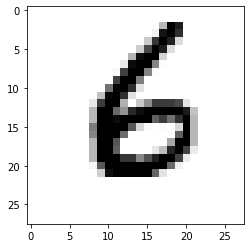

In [6]:
images, labels  = next(iter(train_loader))
print(images.shape)
print(labels.shape)
# printing random image and seeing
plt.imshow(images[random.randint(0,len(images))].numpy().squeeze(), cmap='gray_r')

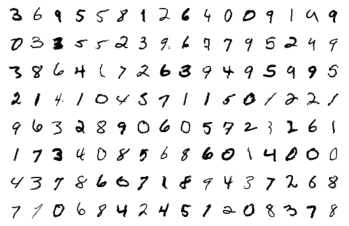

In [7]:
# Looking at more images
figure = plt.figure()
for index in range(1, len(images) + 1): # assumption: batch size would be atleast 8
    plt.subplot(8, int(len(images)/8), index)
    plt.axis('off')
    plt.imshow(images[index-1].numpy().squeeze(), cmap='gray_r')

# Model

In [8]:
class Network(nn.Module):
  def __init__(self):
    super(Network,self).__init__() # extending super class method
    
    drop_out_value = 0.1

    # Input Block
    self.convblock1 = nn.Sequential(
        nn.Conv2d(1,18,3 , bias= False ), # In- 1x28x28, Out- 16x26x26, RF- 3x3, Jump_in -1, Jump_out -1
        nn.ReLU(),
        nn.BatchNorm2d(18),# affine=False),
        nn.Dropout(drop_out_value)
    ) 

    # Conv Block 2
    self.convblock2 = nn.Sequential(
        nn.Conv2d(18,16,3, bias= False ), # In- 16x26x26, Out- 16x24x24, RF- 5x5, Jump_in -1, Jump_out -1
        nn.ReLU(),
        nn.BatchNorm2d(16),# affine=False),
        nn.Dropout(drop_out_value)
    ) 

    # Conv Block 3
    self.convblock3 = nn.Sequential(
        nn.Conv2d(16,16,3, bias= False ), # In- 16x24x24, Out- 16x22x22, RF- 7x7, Jump_in -1, Jump_out -1
        nn.ReLU(),
        nn.BatchNorm2d(16),# affine=False),
        nn.Dropout(drop_out_value)
    ) 

    # Transition Block 1 (this also includes a conv block)
    self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2) # In- 16x22x22, Out- 16x11x11, RF- 8x8, Jump_in -1, Jump_out -2
    # self.convblock4 = nn.Sequential(
    #     nn.Conv2d(32,16,1), # In- 32x12x12, Out- 16x12x12, RF- 8x8, Jump_in -2, Jump_out -2
    #     nn.ReLU(),
    #     nn.BatchNorm2d(16),
    #     nn.Dropout(drop_out_value)
    # ) 

    # Conv Block 5
    self.convblock5 = nn.Sequential(
        nn.Conv2d(16,16,3, bias= False ), # In- 16x11x11, Out- 16x9x9, RF- 12x12, Jump_in -2, Jump_out -2
        nn.ReLU(),
        nn.BatchNorm2d(16),# affine=False),
        nn.Dropout(drop_out_value)
    ) 

    # Conv Block 6
    self.convblock6 = nn.Sequential(
        nn.Conv2d(16,16,3, bias= False ), # In- 16x9x9, Out- 16x7x7, RF- 16x16, Jump_in -2, Jump_out -2
        nn.ReLU(),
        nn.BatchNorm2d(16),# affine=False),
        nn.Dropout(drop_out_value)
    ) 

    # Output Block
    self.convblock7 = nn.Sequential(
        nn.Conv2d(16,10,1, bias= False ), # In- 16x7x7, Out- 10x7x7, RF- 16x16, Jump_in -2, Jump_out -2
        # nn.ReLU()
        # ,
        # nn.BatchNorm2d(10, affine=True),
        # nn.Dropout(drop_out_value)
    ) 

    self.gap = nn.AvgPool2d(7) # In- 10x7x7, Out- 10x1x1, RF- 16x16, Jump_in -2, Jump_out -2

  
  def forward(self,x):

    x = self.convblock1(x)
    x = self.convblock2(x)
    x = self.convblock3(x)

    x = self.pool1(x)
    # x = self.convblock4(x)
    x = self.convblock5(x)
    x = self.convblock6(x)

    x = self.convblock7(x)

    x = self.gap(x)

    # Flattening
    x = x.view(-1,10)
    return F.log_softmax(x,dim=-1)

# model = Network()
# print(model)

## Model Params

In [9]:
device = torch.device("cuda" if cuda else "cpu")
print(device)
model = Network().to(device)
# print(model)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 18, 26, 26]             162
              ReLU-2           [-1, 18, 26, 26]               0
       BatchNorm2d-3           [-1, 18, 26, 26]              36
           Dropout-4           [-1, 18, 26, 26]               0
            Conv2d-5           [-1, 16, 24, 24]           2,592
              ReLU-6           [-1, 16, 24, 24]               0
       BatchNorm2d-7           [-1, 16, 24, 24]              32
           Dropout-8           [-1, 16, 24, 24]               0
            Conv2d-9           [-1, 16, 22, 22]           2,304
             ReLU-10           [-1, 16, 22, 22]               0
      BatchNorm2d-11           [-1, 16, 22, 22]              32
          Dropout-12           [-1, 16, 22, 22]               0
        MaxPool2d-13           [-1, 16, 11, 11]               0
           Conv2d-14             [

# Training and Testing

## Training

In [10]:
# Training Function
train_losses = [] # to capture train losses over training epochs
train_accuracy = [] # to capture train accuracy over training epochs

def train(model,device, train_loader,optimizer,epoch):
  model.train() # setting the model in training mode
  pbar = tqdm(train_loader) # putting the iterator in pbar
  correct = 0 # for accuracy numerator
  processed =0 # for accuracy denominator

  for batch_idx, (images,labels) in enumerate(pbar):
    images, labels = images.to(device),labels.to(device)#sending data to CPU or GPU as per device
    optimizer.zero_grad() # setting gradients to zero to avoid accumulation

    y_preds = model(images) # forward pass, result captured in y_preds (plural as there are many images in a batch)
    # the predictions are in one hot vector

    loss = F.nll_loss(y_preds,labels) # capturing loss
    train_losses.append(loss) # to capture loss over many epochs

    loss.backward() # backpropagation
    optimizer.step() # updating the params

    preds = y_preds.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += preds.eq(labels.view_as(preds)).sum().item()
    processed += len(images)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}%')
    train_accuracy.append(100*correct/processed)


## Test

In [11]:
# Test Function
test_losses = [] # to capture test losses 
test_accuracy = [] # to capture test accuracy 

def test(model,device, test_loader):
  model.eval() # setting the model in evaluation mode
  test_loss = 0
  avg_epoch_test_loss =[]
  correct = 0 # for accuracy numerator

  with torch.no_grad():
    for (images,labels) in test_loader:
      images, labels = images.to(device),labels.to(device)#sending data to CPU or GPU as per device
      outputs = model(images) # forward pass, result captured in outputs (plural as there are many images in a batch)
      # the outputs are in batch size x one hot vector 

      test_loss = F.nll_loss(outputs,labels, reduction='sum').item()  # sum up batch loss
      preds = outputs.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
      correct += preds.eq(labels.view_as(preds)).sum().item()

    test_loss /= len(test_loader.dataset) # average test loss
    test_losses.append(test_loss) # to capture loss over many batches
    avg_epoch_test_loss.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

    test_accuracy.append(100*correct/len(test_loader.dataset))
  return float("{:.4f}".format(np.average(avg_epoch_test_loss)))


## Execution

In [12]:

## Weight initialization

def weights_init(m):
    if isinstance(m, nn.Conv1d):
      nn.init.xavier_normal_(m.weight)


In [21]:
model =  Network().to(device)
model.apply(weights_init)
optimizer = optim.SGD(model.parameters(), lr=0.3, momentum=0.9)
# optimizer = optim.Adam(model.parameters(), lr=0.3)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, threshold=0.0001, threshold_mode='rel', cooldown=0, min_lr=0, eps=1e-08)
# LR_GAMMA = 0.5
from torch.optim.lr_scheduler import StepLR,ReduceLROnPlateau,ExponentialLR
# scheduler = StepLR(optimizer, step_size=4, gamma=0.1)
scheduler = ReduceLROnPlateau(optimizer, factor = 0.1, patience = 2, threshold =  0.0002)
# scheduler = ExponentialLR (optimizer, gamma =0.3)


EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch+1 , "Current LR : ", optimizer.param_groups[0]['lr'])
    train(model, device, train_loader, optimizer, epoch)
    curr_lr = optimizer.param_groups[0]['lr']
    # print(f'current learning rate :', curr_lr)
    val_loss = test(model, device, test_loader)
    # print(f'current learning rate :{curr_lr} and val_loss is {val_loss}')
    scheduler.step(val_loss)
    # if epoch > 5:
    #   optimizer = optim.SGD(model.parameters(), lr=curr_lr*LR_GAMMA, momentum=0.9)


    

EPOCH: 1 Current LR :  0.3


Loss=0.139520063996315 Batch_id=468 Accuracy=93.25%: 100%|██████████| 469/469 [00:18<00:00, 25.54it/s]



Test set: Average loss: 0.0004, Accuracy: 9740/10000 (97.40%)

EPOCH: 2 Current LR :  0.3


Loss=0.05833831802010536 Batch_id=468 Accuracy=97.50%: 100%|██████████| 469/469 [00:18<00:00, 25.60it/s]



Test set: Average loss: 0.0000, Accuracy: 9821/10000 (98.21%)

EPOCH: 3 Current LR :  0.3


Loss=0.06345055252313614 Batch_id=468 Accuracy=97.92%: 100%|██████████| 469/469 [00:18<00:00, 25.64it/s]



Test set: Average loss: 0.0000, Accuracy: 9866/10000 (98.66%)

EPOCH: 4 Current LR :  0.3


Loss=0.019111178815364838 Batch_id=468 Accuracy=98.23%: 100%|██████████| 469/469 [00:18<00:00, 25.64it/s]



Test set: Average loss: 0.0001, Accuracy: 9889/10000 (98.89%)

EPOCH: 5 Current LR :  0.3


Loss=0.047748420387506485 Batch_id=468 Accuracy=98.38%: 100%|██████████| 469/469 [00:18<00:00, 25.01it/s]



Test set: Average loss: 0.0000, Accuracy: 9892/10000 (98.92%)

EPOCH: 6 Current LR :  0.03


Loss=0.003540727309882641 Batch_id=468 Accuracy=98.81%: 100%|██████████| 469/469 [00:18<00:00, 25.10it/s]



Test set: Average loss: 0.0002, Accuracy: 9921/10000 (99.21%)

EPOCH: 7 Current LR :  0.03


Loss=0.02940441109240055 Batch_id=468 Accuracy=98.91%: 100%|██████████| 469/469 [00:18<00:00, 25.24it/s]



Test set: Average loss: 0.0000, Accuracy: 9925/10000 (99.25%)

EPOCH: 8 Current LR :  0.03


Loss=0.020323188975453377 Batch_id=468 Accuracy=98.97%: 100%|██████████| 469/469 [00:18<00:00, 25.47it/s]



Test set: Average loss: 0.0000, Accuracy: 9933/10000 (99.33%)

EPOCH: 9 Current LR :  0.003


Loss=0.00983172282576561 Batch_id=468 Accuracy=98.96%: 100%|██████████| 469/469 [00:18<00:00, 25.70it/s]



Test set: Average loss: 0.0004, Accuracy: 9927/10000 (99.27%)

EPOCH: 10 Current LR :  0.003


Loss=0.06633401662111282 Batch_id=468 Accuracy=99.03%: 100%|██████████| 469/469 [00:18<00:00, 25.61it/s]



Test set: Average loss: 0.0002, Accuracy: 9931/10000 (99.31%)

EPOCH: 11 Current LR :  0.003


Loss=0.00830322690308094 Batch_id=468 Accuracy=98.95%: 100%|██████████| 469/469 [00:18<00:00, 25.10it/s]



Test set: Average loss: 0.0006, Accuracy: 9930/10000 (99.30%)

EPOCH: 12 Current LR :  0.00030000000000000003


Loss=0.021249456331133842 Batch_id=468 Accuracy=98.99%: 100%|██████████| 469/469 [00:19<00:00, 24.04it/s]



Test set: Average loss: 0.0002, Accuracy: 9931/10000 (99.31%)

EPOCH: 13 Current LR :  0.00030000000000000003


Loss=0.0038580235559493303 Batch_id=468 Accuracy=98.99%: 100%|██████████| 469/469 [00:18<00:00, 25.67it/s]



Test set: Average loss: 0.0000, Accuracy: 9932/10000 (99.32%)

EPOCH: 14 Current LR :  0.00030000000000000003


Loss=0.017270246520638466 Batch_id=468 Accuracy=99.03%: 100%|██████████| 469/469 [00:18<00:00, 25.45it/s]



Test set: Average loss: 0.0000, Accuracy: 9933/10000 (99.33%)

EPOCH: 15 Current LR :  3.0000000000000004e-05


Loss=0.011554584838449955 Batch_id=468 Accuracy=99.02%: 100%|██████████| 469/469 [00:18<00:00, 25.49it/s]



Test set: Average loss: 0.0004, Accuracy: 9932/10000 (99.32%)



Text(0.5, 1.0, 'Test Accuracy')

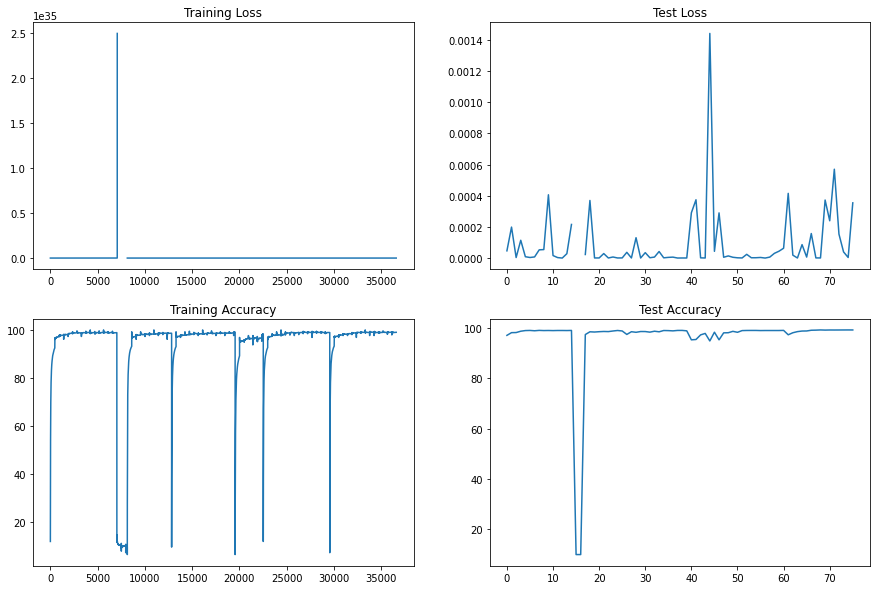

In [22]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
# axs[0, 0].plot(train_losses)
axs[0, 0].plot([t.cpu().item() for t in train_losses])
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_accuracy)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_accuracy)
axs[1, 1].set_title("Test Accuracy")